In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme(font_scale=1.5)

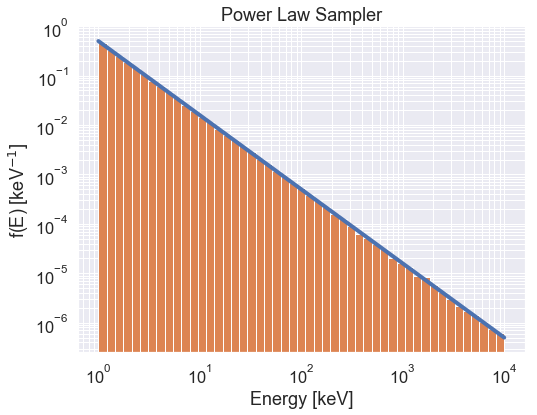

In [2]:
f_powerLaw = lambda x, alpha, Emin: (alpha-1) / Emin * (x / Emin)**-alpha
sampler = lambda U, alpha, Emin: np.power(U, (1/(1-alpha))) * Emin;

Emin = 1;
alpha = 1.5;

E = np.logspace(np.log10(Emin), 4, 100)

N = 1e5

plt.figure(figsize=(8,6)); plt.grid(True, which='both')
plt.loglog(E, f_powerLaw(E, alpha, Emin), linewidth=4);
plt.xlabel('Energy [keV]');
plt.ylabel('f(E) [keV$^{-1}$]');

plt.hist(sampler(np.random.rand(int(N), 1), alpha, Emin), bins=np.logspace(np.log10(Emin), 4), density=True);

plt.title('Power Law Sampler');

Rand: 105.67 keV, Theory: 127.50 keV


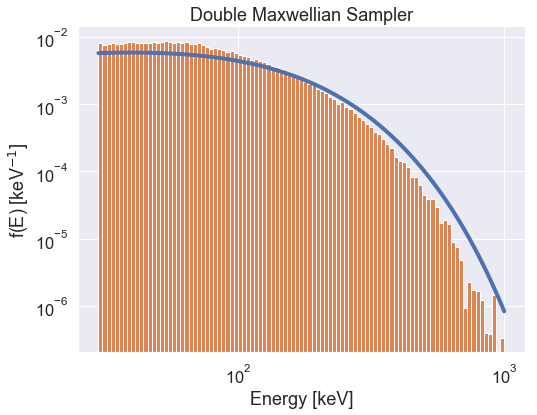

In [3]:
f_doubleMaxwell = lambda x, T1, T2: np.sqrt(x/np.pi) * (1/T1)**(3/2) * np.exp(-x/T1) + \
                      np.sqrt(x/np.pi) * (1/T2)**(3/2) * np.exp(-x/T2);

f_exponential = lambda x, E0: 1/E0 * np.exp(-x/E0); 

T1 = 70;
T2 = 100;

Nsamples = 1e5;
i = 0;
c = 1;
samples = np.zeros([int(N), 1]);

while i < Nsamples:
    
    # helper distribution (exponential with E0 = (T1 + T2)/2
    Y = -(T1+T2)/2 * np.log(np.random.rand());

    # Accept/reject algorithm
    if np.random.rand() < f_doubleMaxwell(Y, T1, T2)/(c * f_exponential(Y, (T1 + T1)/2)):
        
        # If loop entered, accept sample point 
        samples[i] = Y;
        
        i += 1;

print("Rand: %.2f keV, Theory: %.2f keV" % (np.mean(samples), 0.75 * (T1+T2)))
E = np.logspace(np.log10(30), 3, 100);

plt.figure(figsize=(8,6));
plt.loglog(E, f_doubleMaxwell(E, T1, T2), linewidth=4);

plt.hist(samples, bins=E, density=True);

plt.xlabel('Energy [keV]');
plt.ylabel('f(E) [keV$^{-1}$]');
plt.title('Double Maxwellian Sampler');

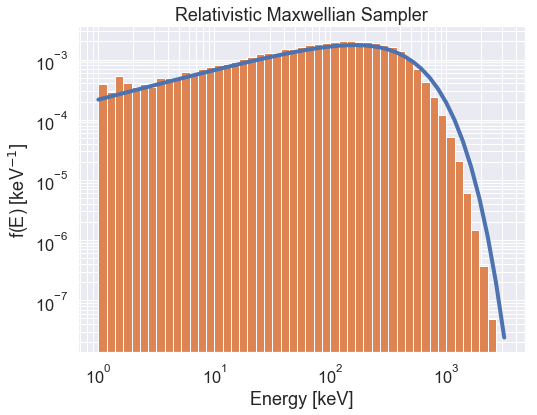

In [4]:
from scipy.special import kn

f_relMaxwell = lambda x, T: (1 + x/511)**2 * np.sqrt(1 - 1/(1 + x/511)**2) / ( 511 * (T/511) * kn(2, 511/T) ) * \
                            np.exp(-(1 + x/511) / (T/511));

g = lambda x, E0: 1/E0 * np.exp(-x/E0); 

T = 200;

Nsamples = 1e5;
i = 0;
c = 2;
samples = np.zeros([int(N), 1]);

while i < Nsamples:
    
    # helper distribution (exponential with E0 = T on [1, inf)
    Y = -T * np.log(np.random.rand());

    # Accept/reject algorithm
    if np.random.rand() < f_relMaxwell(Y, T)/(c * f_exponential(Y, T)):
        
        # If loop entered, accept sample point 
        samples[i] = Y;
        
        i += 1;

E = np.logspace(0, 3.5);

plt.figure(figsize=(8,6)); plt.grid(True, which='both')
plt.loglog(E, f_relMaxwell(E, T), linewidth=4);

plt.hist(samples, bins=E, density=True)

plt.xlabel('Energy [keV]');
plt.ylabel('f(E) [keV$^{-1}$]');

plt.title('Relativistic Maxwellian Sampler');

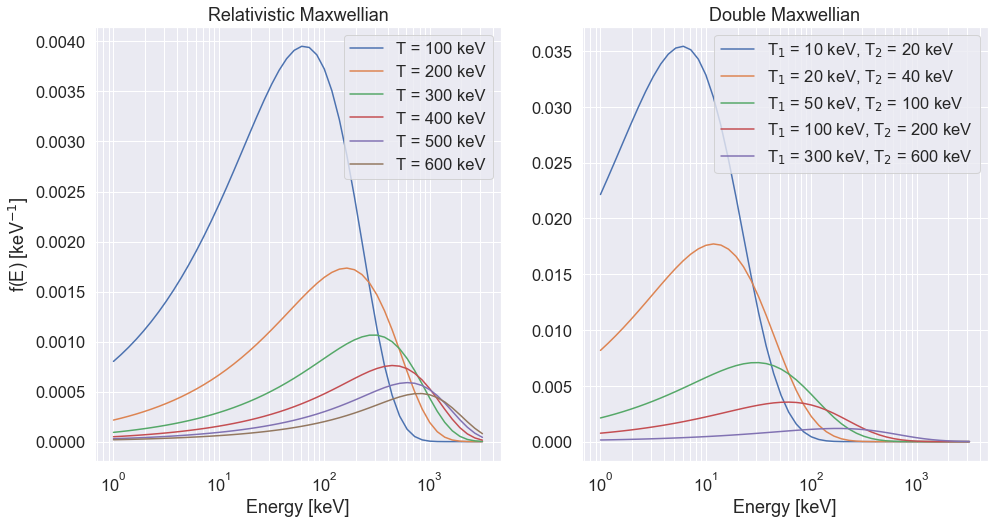

In [6]:
plt.figure(figsize=(16,8)); plt.subplot(1,2,1); plt.grid(True, which='both');
for Ts in [100, 200, 300, 400, 500, 600]:
    plt.plot(E, f_relMaxwell(E, Ts), label='T = %.0f keV' % Ts);

plt.xscale('log')
plt.xlabel('Energy [keV]');
plt.ylabel('f(E) [keV$^{-1}$]');
plt.legend();
plt.title('Relativistic Maxwellian')

plt.subplot(1,2,2); plt.grid(True, which='both');
for Ts in [10, 20, 50, 100, 300]:
    plt.plot(E, f_doubleMaxwell(E, Ts, Ts*2), label='T$_1$ = %.0f keV, T$_2$ = %.0f keV' % (Ts, Ts*2));
    
plt.xscale('log');
plt.legend();
plt.xlabel('Energy [keV]');
plt.title('Double Maxwellian');

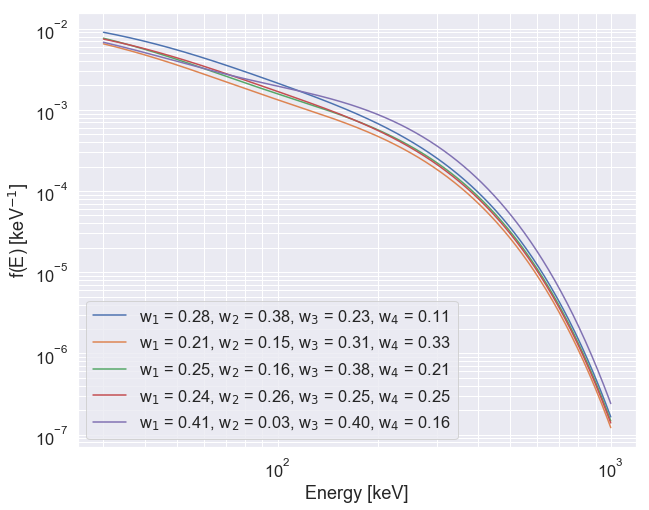

In [7]:

E = np.logspace(np.log10(30), 3., 500)

Ts = 20;
plt.figure(figsize=(10,8)); plt.grid(True, which='both');
for i in range(0, 5):
    
    w = np.random.rand(4,1);
    w /= np.sum(w);
    
    plt.plot(E, 
                w[0] * f_relMaxwell(E, Ts*4) + 
                w[1] * f_doubleMaxwell(E, Ts, Ts*2) + 
                w[2] * f_exponential(E, Ts) + 
                w[3] * f_powerLaw(E, 1e0, 2), 
             label='w$_1$ = %.2f, w$_2$ = %.2f, w$_3$ = %.2f, w$_4$ = %.2f' % (w[0], w[1], w[2], w[3]))
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('f(E) [keV$^{-1}$]');
plt.legend();

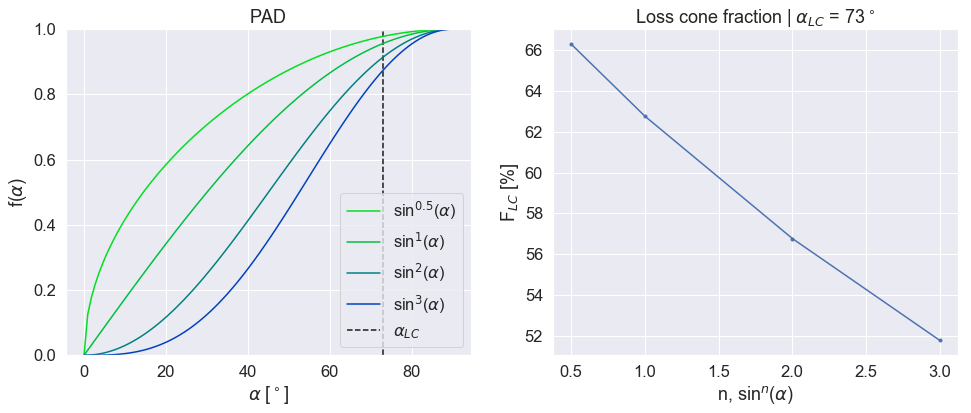

In [8]:
def findLossConeFraction(alpha, alphaLC, f):
    
    alphaLim = alpha[alpha < alphaLC]
    
    upper = np.trapz(f(alphaLim) * np.sin(alphaLim), x=alphaLim)
    lower = np.trapz(f(alpha) * np.sin(alpha),       x=alpha)
    
    return upper / lower

f12 = lambda alpha: np.sin(alpha)**(1/2)
f1  = lambda alpha: np.sin(alpha)
f2  = lambda alpha: np.sin(alpha)**2
f3  = lambda alpha: np.sin(alpha)**3

alpha   = np.linspace(0, np.pi/2, 100);
alphaLC = np.arcsin(np.sqrt(((6371+100)/(6371+300))**3)) # LC at 300 km altitude, ~72.8 deg


plt.figure(figsize=(16,6)); plt.subplot(1,2,1);

for i in [0.5, 1, 2, 3]:
    plt.plot(np.rad2deg(alpha), np.sin(alpha)**(i), label=r'sin$^{%s}$($\alpha$)' % i, c=[0, 1-i/4, i/4]);


plt.vlines(np.rad2deg(alphaLC), 0, 1, linestyle='--', label=r'$\alpha_{LC}$');

#plt.yscale('log')
plt.ylim(0,1)

plt.legend();
plt.xlabel(r'$\alpha$ [$^\circ$]');
plt.ylabel(r'f($\alpha$)');
plt.title('PAD')


plt.subplot(1,2,2); plt.grid(True, which='both');
plt.plot([0.5, 1, 2, 3], 100*np.array([findLossConeFraction(alpha, alphaLC, f12),
                            findLossConeFraction(alpha, alphaLC, f1),
                            findLossConeFraction(alpha, alphaLC, f2),
                            findLossConeFraction(alpha, alphaLC, f3)]), '.-')

plt.xlabel(r'n, sin$^n$($\alpha$)'); plt.ylabel('F$_{LC}$ [%]');
plt.title(r'Loss cone fraction | $\alpha_{LC}$ = %.0f$^\circ$' % 
          np.rad2deg(alphaLC));

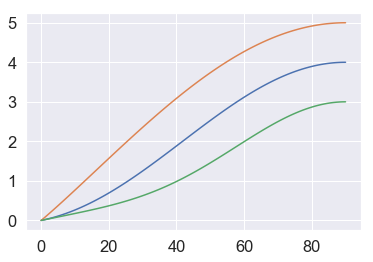

In [24]:
newPAD = lambda C, alpha: C[0] * np.sin(alpha) + \
                          C[1] * np.sin(alpha)**C[2]


plt.figure()
plt.plot(np.rad2deg(alpha), newPAD([1, 3, 2], alpha));
plt.plot(np.rad2deg(alpha), newPAD([4, 1, 1.5], alpha));
plt.plot(np.rad2deg(alpha), newPAD([1, 2, 4], alpha));

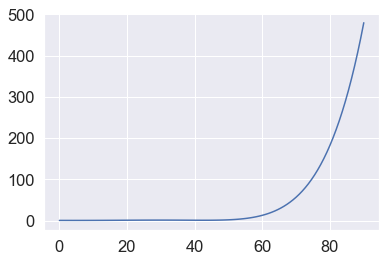

In [27]:
from scipy.special import legendre


PAD = np.zeros(len(alpha))

coefs = []

for i in range(0, 2):
    P = legendre(i)
    PAD += coefs[i] * P(alpha)

plt.figure();
plt.plot(np.rad2deg(alpha), PAD);